In [58]:
#Download installs
import seaborn as sns
import matplotlib.pyplot as plt
!pip install pandas
!pip install numpy
import pandas as pd
import numpy as np


In [59]:
#Import dataset

transactions = pd.read_csv('transactions.csv', parse_dates = (['date']))
calendar = pd.read_csv('calendar.csv', parse_dates=(['date']))
products = pd.read_csv('products.csv')

#Merge datasets

df = transactions.merge(calendar, on='date', how='left')
df = df.merge(products, on = 'product_id', how = 'left')

In [60]:

#Create a revenue column 
df = df.assign(revenue = df['price'] * df['quantity'])

#Daily revenue
daily_revenue  = (
    df.groupby('date')['revenue']
    .sum()
    .reset_index()
    .sort_values('date')

    )

daily_revenue.head()

,date,revenue
0,2025-01-01,35.0
1,2025-01-02,67.5
2,2025-01-03,50.0
3,2025-01-04,52.0
4,2025-01-05,42.5


In [61]:
#Find top 5 products by revenue 

top_5_products = (
    df.groupby('product_name')['revenue']
    .sum()
    .reset_index()
    .sort_values('revenue')
    )

top_5_products.head()

,product_name,revenue
4,Widget E,32.0
3,Widget D,40.0
1,Widget B,45.0
2,Widget C,60.0
0,Widget A,70.0


In [62]:
#Categorize products by revenue

category_summary = (
    df.groupby('category')['revenue']
    .sum()
    .reset_index()
    .sort_values('revenue', ascending= False)     
)

category_summary

,category,revenue
2,Tools,115.0
1,Gadgets,100.0
0,Accessories,32.0


In [63]:
#Revenue based on day of the week

weekly_revenue = (
    df.groupby('day_of_week')['revenue']
    .sum()
    .reset_index()
    .sort_values('revenue')
)
weekly_revenue.head()

,day_of_week,revenue
4,Wednesday,35.0
2,Sunday,42.5
0,Friday,50.0
1,Saturday,52.0
3,Thursday,67.5


In [64]:
#weekly_revenue 

iso = df['date'].dt.isocalendar()
df = df.assign(year = iso.year.astype(int), week = iso.week.astype(int))

weekly_revenue = (
    df.groupby(['year', 'week'], as_index=False)['revenue']
    .sum()
    .reset_index()
    .sort_values(['year', 'week'])    
)

weekly_revenue



,index,year,week,revenue
0,0,2025,1,247.0


In [65]:
#YoY change in revenue

prev = weekly_revenue.rename(columns={"revenue": "revenue_prev"}).copy()
prev["year"] = prev["year"] + 1

yoy = weekly_revenue.merge(prev, on=["year","week"], how="left")
yoy["yoy_pct"] = (yoy["revenue"] - yoy["revenue_prev"]) / yoy["revenue_prev"]

yoy.head(10)


,index_x,year,week,revenue,index_y,revenue_prev,yoy_pct
0,0,2025,1,247.0,NaN,NaN,NaN


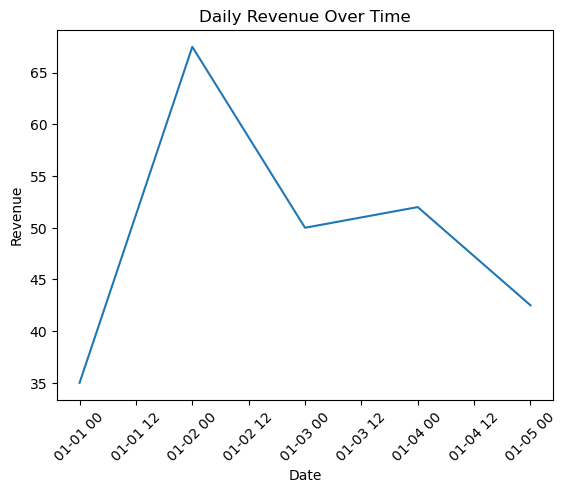

In [66]:
#Daily Revenue Visualization
plt.plot(daily_revenue['date'], daily_revenue['revenue'])
plt.title('Daily Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()



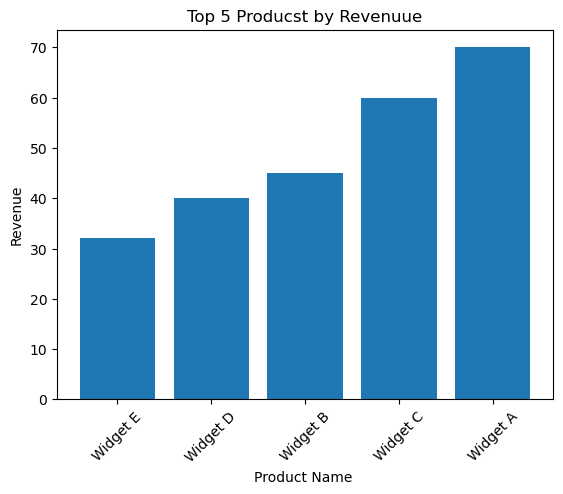

In [67]:
#Top 5 products Visualization
plt.bar(top_5_products['product_name'], top_5_products['revenue'])
plt.title('Top 5 Producst by Revenuue')
plt.xlabel('Product Name ')
plt.ylabel('Revenue')
plt.xticks(rotation=45)
plt.show()

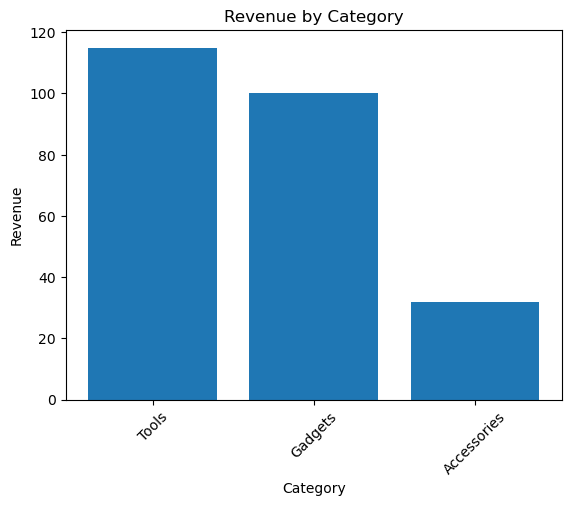

In [68]:
#Revenue by Category Visualization
plt.bar(category_summary['category'], category_summary['revenue'])
plt.title('Revenue by Category')
plt.xlabel('Category')  
plt.ylabel('Revenue')
plt.xticks(rotation=45)     
plt.show()

In [69]:
#Descriptive statistics

desc = df[['quantity', 'price', 'revenue']].describe().T
desc

,count,mean,std,min,25%,50%,75%,max
quantity,10.0,2.4,1.349897,1.0,1.25,2.00,3.0,5.0
price,10.0,12.3,4.871687,7.5,8.50,10.00,15.0,20.0
revenue,10.0,24.7,7.153865,15.0,20.00,21.25,30.0,37.5


In [70]:
# Confidence level around mean 

rng = np.random.default_rng(42) # Random number generator
rev = df['revenue'].to_numpy() #Create numpy array 

#Number of boostrap examples 
b = 5000
boots = []
n = len(rev) #sample size

for _ in range (b):
    sample = rng.choice(rev, size = n, replace = True)
    boots.append(sample.mean())


ci_low, ci_high = np.percentile(boots,[2.5, 97.5 ])


#print results 
rev_mean = df['revenue'].mean()
rev_mean, ci_low, ci_high



(24.7, 20.7, 29.0)

# Confidence level around the mean 
- What we look for when we run this code is the estimated ranges of the mean in population. 
We do this to expose uncertainty involving noise when using a singluar mean. This also helps with decsision making, so instead of saying one value for the likely average value you can communicate rangles between lower and higher confidence levels 

In [71]:
#Standard error test 

#Normal distrubtion 
p_hat = df['is_holiday'].mean()
n = len(df) #Sample size 


#Standard error 
se = p_hat *(1- p_hat)/n
low, hi = p_hat - 1.96*se, p_hat + 1.96*se # z-score

#results
print('low',low)
print('hi',hi)
print('p_hat', p_hat)


low 0.16864
hi 0.23136
p_hat 0.2


# Standard error proportion test 
 What this test refers to is the true proportion of holidays in the popuplation based on your sample. Your mean is 0.20(20%), which mean 20% of your observations are holidays, with confidence intervals of (16.8% - 23.1%) which is a stable ranges of number. We use this type of testing comapre groups like A or B, or if you want to understand sampling uncerainty. 


In [72]:

#Two way proportion z-test

import math 

n_a, conv_a = 1000, 120 # 12% conversion rate 
n_b, conv_b = 980, 150 # 13.51% conversion rate 

pA = conv_a / n_a 
pB = conv_b / n_b 

# pool proportion 
p_pool = (conv_a + conv_b) / (n_a + n_b )

#two way proportion]
se = math.sqrt(p_pool * (1 - p_pool) *(1/n_a + 1/n_b))
z = (pB - pA) / se # z test 

def norm_cdf(x):
    return 0.5 * (1 + math.erf(x / math.sqrt(2)))

p_value = 2 * (1 - norm_cdf(abs(z)))

{'pA':pA, 'pB':pB, "z":z, 'p_value':p_value}


{'pA': 0.12,
 'pB': 0.15306122448979592,
 'z': 2.143308223199548,
 'p_value': 0.03208835696622736}

# Two way proportion tests
- Two way proportion tests are used to explain and compare sucess rates of two groups. Are proportions truly different or is the difference just random chance. After testing the conversion rate, we get a result of 2.14 z score and a p-value of 0.032 which is under 0.05, so you can say your 95% confident that Group B is better than Group A and not due to chance. 


In [73]:
# Pearson correlation 
corr = df[['price', 'revenue']].corr()
print("Pearson correlation of price and revenue:", corr)

Pearson correlation of price and revenue:             price   revenue
price    1.000000 -0.500857
revenue -0.500857  1.000000


# Persion Correlation
- Correlation explains the relationship and patterns between varriables. Here we see that price and revenue are negatively correlated to each other. On top of that we can see that the correlation reuslts in a -0.50 which is a moderatley negative result. To communicate a result like this to someone is to say 'When price increases, revenue tends to decrease on average. 

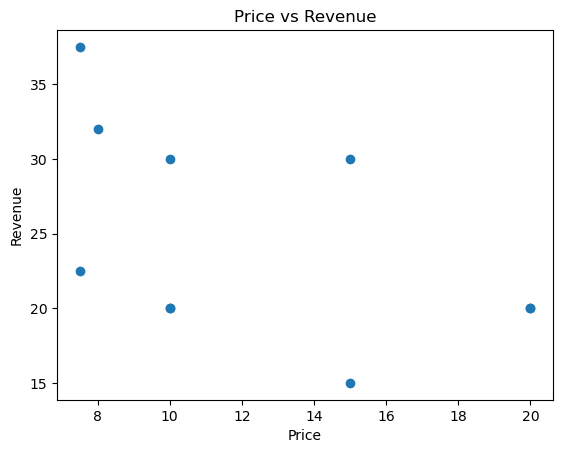

In [74]:
# Visual Relationship between price and revenue

plt.scatter(df['price'], df['revenue'])
plt.title('Price vs Revenue')
plt.xlabel('Price')
plt.ylabel('Revenue')
plt.show()

In [75]:
# Spearman reduces sensitivity to outliers. 
# If pearson and spearman disagree your relationship may be nonlinear

spearman = df[['price', 'revenue']].corr(method = 'spearman')

print('Spearman corelation for price and revenue', spearman)

Spearman corelation for price and revenue             price   revenue
price    1.000000 -0.625051
revenue -0.625051  1.000000


# Spearman correlation 
- Spearman reduces sensitivity to outliers which makes it a well defined test. Also, if spearman disagress with persion your relationship may be nonlinear. 

In [76]:
#partaial corr 
!pip install pingouin
import pingouin as pg 

partial_corr = pg.partial_corr(data = df, x = 'price', y = 'revenue', covar = 'quantity')
print(partial_corr)

          n         r         CI95%     p-val
pearson  10  0.700326  [0.07, 0.93]  0.035646


# Partial Correlation 
This checks for an incluence X and Y may have after controlling for a lurking variable Z. The result tells us that there is indeed a strong relationship between X and Y when holding qauntity constant. In other terms, When price increase, revenue on average tends to increase as well. This tell us the negative pearson correaltion was heavily influenced by quantity. 

In [77]:
# Simpson Paradox correlation

# Quantity is numeric which means you need to create bins for the simpson paradox to work. 
df['quantity_bins'] = pd.qcut(df['quantity'], q =3, labels = ('low', 'medium', 'high')) 


out = [] # Create list object
for cat, sub in df.groupby('quantity_bins'):
    sub2 = sub[['price', 'revenue']].dropna() # drop any nan values 
    if len(sub2) >=3: # Length of rows 
        c = sub2.corr().loc['price', 'revenue'] # Find correlation between the two features 
        out.append((cat, c, len(sub2))) # Add it to the list

#Print Results
for cat, c, n in out:
    print(f'quantity = {cat:12s} corr = {c:.3f} n = {n}')


quantity = low          corr = 1.000 n = 3
quantity = medium       corr = 1.000 n = 3
quantity = high         corr = -0.023 n = 4


C:\Users\dmiracju\AppData\Local\Temp\ipykernel_20652\2275364306.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for cat, sub in df.groupby('quantity_bins'):


# Simpson Pardox
- Within the lower and medium quantity levels, price and revenue move tightly togther. But when movef up into the higher levels of quantity revenue tends to decrease aacross the dataset which is the reason pearson correlation captures a negavite relationship and a paradox is created 

In [78]:
#Transform category into 0's and 1's 

encoded = pd.get_dummies(df['category'], prefix ='cat')
encoded.head()

#Assing to dataframe
df = pd.concat([df, encoded], axis = 1)

In [79]:

#Use category and product stats for training data 

# Sales counts via Product id
df['purchase_sales_counts'] = df['product_id'].map(df['product_id'].value_counts())
df

,transaction_id,product_id,quantity,price,date,day_of_week,is_holiday,product_name,category,revenue,year,week,quantity_bins,cat_Accessories,cat_Gadgets,cat_Tools,purchase_sales_counts
0,1,101,2,10.0,2025-01-01,Wednesday,False,Widget A,Tools,20.0,2025,1,medium,False,False,True,3
1,2,102,1,15.0,2025-01-01,Wednesday,False,Widget B,Tools,15.0,2025,1,low,False,False,True,2
2,3,101,3,10.0,2025-01-02,Thursday,False,Widget A,Tools,30.0,2025,1,high,False,False,True,3
3,4,103,5,7.5,2025-01-02,Thursday,False,Widget C,Gadgets,37.5,2025,1,high,False,True,False,2
4,5,102,2,15.0,2025-01-03,Friday,False,Widget B,Tools,30.0,2025,1,medium,False,False,True,2
5,6,104,1,20.0,2025-01-03,Friday,False,Widget D,Gadgets,20.0,2025,1,low,False,True,False,2
6,7,105,4,8.0,2025-01-04,Saturday,True,Widget E,Accessories,32.0,2025,1,high,True,False,False,1
7,8,101,2,10.0,2025-01-04,Saturday,True,Widget A,Tools,20.0,2025,1,medium,False,False,True,3
8,9,103,3,7.5,2025-01-05,Sunday,False,Widget C,Gadgets,22.5,2025,1,high,False,True,False,2
9,10,104,1,20.0,2025-01-05,Sunday,False,Widget D,Gadgets,20.0,2025,1,low,False,True,False,2


In [80]:

from sklearn.model_selection import train_test_split

# Target value 
y = df['revenue'] 

#Features 
X = df[[
    'quantity', 'price' ]]

#70/15/15 spli: Train vs Temp (val+test), then temp -> val/test
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size = 0.30, random_state = 42, shuffle = True)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size = 0.50, random_state = 42, shuffle = True)




In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression  # (you can swap for Ridge/Lasso, etc.)
from sklearn.pipeline import Pipeline

# Auto-detect numeric vs categorical columns (exclude the target we already dropped)
num_cols = X_train.select_dtypes(include=["number"]).columns.tolist()
cat_cols = X_train.select_dtypes(include=["object", "category"]).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop",
)

pipe = Pipeline(steps=[
    ("prep", preprocessor),
    ("model", LinearRegression())
])

In [82]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Train
pipe.fit(X_train, y_train)

# Validate
y_val_pred = pipe.predict(X_val)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
r2_val = r2_score(y_val, y_val_pred)

#Print results 
print(f"Validation RMSE: {rmse_val:.3f}")
print(f"Validation R^2:  {r2_val:.3f}")


Validation RMSE: 2.814
Validation R^2:  nan


c:\Users\dmiracju\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\dmiracju\AppData\Local\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:1211: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [83]:
# r2 squared isn't computting check sample size to see if its greater than or equal too 2 
n = len(y_val)
print(n)

1


In [84]:
#Check is validation has any nan values

y_val.isna()

5    False
Name: revenue, dtype: bool

In [85]:
#Check if values are all equal 
y_val.unique()

array([20.])

In [86]:
# Check variance 
y_val_var = np.var(y_val)
revenue_column_var = np.var(df['revenue'])
y_train_var = np.var(y_train)

#Print results 
print('validatin test variance', y_val_var)
print('revenue variance', revenue_column_var)
print('target training variance', y_train_var)


validatin test variance 0.0
revenue variance 46.059999999999995
target training variance 42.88775510204082


## No variance captured in revenue from trainset 
- The validation set isn't capturing variation/spread from the split. 
- This can be due to the random_state or shuffle spitting up and deploying constant numbers into the val data
- This issue leads to r2 squared resulting in nan 
- How do we fix this ? Well if we want to caputure some level of spread in the training data we can group the target variable in to bins (stratification), then stratify it into the train data. 

In [87]:

# Bin revenue into 5 groups for stratification
y_bins = pd.qcut(df['revenue'], q=2, labels=False, duplicates='drop')

# Train vs temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, stratify=y_bins, random_state=50, shuffle=True
)

#Bin y_temp into 5 groups for stratification
y_temp_bins = pd.qcut(y_temp, q=2, labels=False, duplicates='drop')
# Split temp -> val/test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, stratify=y_temp_bins, random_state=50, shuffle=True)



In [88]:
# Review variation accuracy before modeling 
y_val = np.var(y_val)
revenue_variation = np.var(y_bins)

# Dispersion Results 
print(f'validation variation {y_val:.3f}')
print(f'revenue variation {revenue_variation: .3f}')



validation variation 0.000
revenue variation  0.250


In [89]:
# Stratification still isn't caputuring variance in revenue
# which is leading to a nan value for r2-square in model evalualtion
# best case move would either be to report on RMSE or Use Cross-val

## Variance Issue
- Stratification still isn't capturing variance, which is leading to r2 computing as nan in model evalution. 
- Best senario would be to move into cross-val-score or report on MSE and MAE

In [90]:
from sklearn.model_selection import KFold, cross_val_score

#Cross validation 
# ---------- 5) Cross-validation ----------
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# R² (higher is better)
r2_scores = cross_val_score(pipe, X, y, cv=kf, scoring="r2")

# RMSE (lower is better) – computed from negative MSE
rmse_scores = np.sqrt(-cross_val_score(pipe, X, y, cv=kf, scoring="neg_mean_squared_error"))

print("R² per fold:   ", np.round(r2_scores, 3))
print("RMSE per fold: ", np.round(rmse_scores, 3))
print(f"R² mean±std:    {r2_scores.mean():.3f} ± {r2_scores.std():.3f}")
print(f"RMSE mean±std:  {rmse_scores.mean():.3f} ± {rmse_scores.std():.3f}")


R² per fold:    [ 0.211  0.     0.73   0.098 -7.004]
RMSE per fold:  [3.33  1.77  2.597 4.748 7.78 ]
R² mean±std:    -1.193 ± 2.917
RMSE mean±std:  4.045 ± 2.109


## Cross-val-score
- These numbers show that model is overfitting and unstable. You may want to check your relationship between the features and target value. 

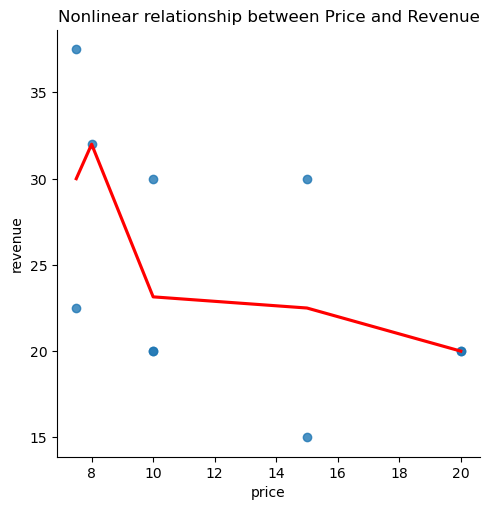

In [91]:

sns.lmplot(data=df, x="price", y="revenue", lowess=True, line_kws={'color':'red'})
plt.title("Nonlinear relationship between Price and Revenue")
plt.show()

## Nonlinear Relationship
- Your model is unstable becuase you are trying to run Multiple Linear Regression on a relationship that is nonlinear. 
- This requires a model that can capture sharp cuvers and noise, within the relationship between revenue = price x quantity.

In [92]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score
import numpy as np


x_features = df[['price', 'quantity', 'is_holiday',
 'cat_Accessories', 'cat_Gadgets', 'cat_Tools',
 'purchase_sales_counts']]


poly_model = Pipeline([
    ('scale', StandardScaler()),
    ("poly", PolynomialFeatures(degree=7, include_bias=False)),
    ("model", LinearRegression())
])

R2 = cross_val_score(poly_model, x_features, y, cv = kf, scoring = 'r2')
MSE = -cross_val_score(poly_model, x_features, y, cv = kf, scoring = 'neg_mean_squared_error')


#print results 
print("R² per fold:", np.round(R2, 3))
print("RMSE per fold:", np.round(MSE, 3))
print(f"R² mean±std: {R2.mean():.3f} ± {R2.std():.3f}")
print(f"RMSE mean±std: {MSE.mean():.3f} ± {MSE.std():.3f}")


R² per fold: [-8.07100000e+00  0.00000000e+00  2.82000000e-01 -2.48000000e-01
 -1.79460501e+06]
RMSE per fold: [1.2756100e+02 4.4970000e+01 1.7953000e+01 3.1194000e+01 1.3571708e+07]
R² mean±std: -358922.610 ± 717841.201
RMSE mean±std: 2714385.927 ± 5428661.016


In [93]:
# The model is predicted the results too perfectly 
# Chcek to see if the model just learned the exact mathematical formula of the data 

(df["revenue"] == df["price"] * df["quantity"]).all()

True

### Week 2 Summary
- Polynomial regression captured the nonlinear structure of revenue perfectly.
- The R² = 1.0 shows the model rediscovered an exact mathematical identity, not just a trend.  
- In real-world data, slight variation (noise) would reduce R², reflecting natural randomness.  
- After conclusion the dataset is too small in terms of non deterministic features. Each Feature is essentially deterministic making it more of a mathematical equation not just a prediction. What this means moving foward then is looking at variable/feaures you dont know the futures changes or unseen outcome of in otherwords not a simple multiplication. 

In [94]:
import pandas as pd
df = df.sort_values("date").reset_index(drop=True)  # IMPORTANT for lags

# Model A (demand):
y_qty = df['revenue']

# Model B (revenue forecast): predict future revenue (t+1 row/day/week)
df["revenue_tplus1"] = df["revenue"].shift(-1) # Revenue is determinced by price * quantity, so we shifted it upward 
y_rev = df["revenue_tplus1"]


In [95]:
# Feature engineer product id for training. These features give the model the identity and behavior of each product

g = df.groupby("product_id")

df['prod_qty_mean'] = g['quantity'].transform('mean')
df['prod_price_mean'] = g['quantity'].transform('mean')
df['prod_rev_mean'] = g['quantity'].transform('mean')
df['prod_sales_count'] = g['quantity'].transform('count')


# Each statistic describes the models personaltity 

# Feature engineering 
Here we engineer new characterstics into our dataset to give our model identity and behavior of each category 

In [96]:
# Data mine time features for calendar intelligence a

df['year'] = pd.to_datetime(df['date']).dt.year
df['week'] = pd.to_datetime(df['date']).dt.isocalendar().week.astype(int)
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['month'] = pd.to_datetime(df['date']).dt.month
df['is_weekend'] = df['day_of_week'].isin([5,6]).astype(int)


# Calendar Intelligence 
Time features helps the model understand seasonal, holiday, and weekend sales cycles.  

In [97]:
# Include lag and rolling features for mdoel memory 

df["quantity_lag1"] = df["quantity"].shift(1)
df["quantity_lag7"] = df["quantity"].shift(7)
df["quantity_rolling3"] = df["quantity"].rolling(3).mean()
df["quantity_rolling7"] = df["quantity"].rolling(7).mean()


# Lag Features 
Model can't delibrately look back at the data unless we engineer it too. Lag features gives the model enough information about what has happened in the past. 

In [98]:
# Include lag and rolling features for revenue too 

df['rev_lag1'] = df['revenue'].shift(1)
df['rev_lag7'] = df['revenue'].shift(7)
df['rev_rolling3'] = df['revenue'].rolling(3).mean()
df['rev_rolling7'] = df['revenue'].rolling(7).mean()


In [99]:
df

,transaction_id,product_id,quantity,price,date,day_of_week,is_holiday,product_name,category,revenue,...,month,is_weekend,quantity_lag1,quantity_lag7,quantity_rolling3,quantity_rolling7,rev_lag1,rev_lag7,rev_rolling3,rev_rolling7
0,1,101,2,10.0,2025-01-01,2,False,Widget A,Tools,20.0,...,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,102,1,15.0,2025-01-01,2,False,Widget B,Tools,15.0,...,1,0,2.0,NaN,NaN,NaN,20.0,NaN,NaN,NaN
2,3,101,3,10.0,2025-01-02,3,False,Widget A,Tools,30.0,...,1,0,1.0,NaN,2.000000,NaN,15.0,NaN,21.666667,NaN
3,4,103,5,7.5,2025-01-02,3,False,Widget C,Gadgets,37.5,...,1,0,3.0,NaN,3.000000,NaN,30.0,NaN,27.500000,NaN
4,5,102,2,15.0,2025-01-03,4,False,Widget B,Tools,30.0,...,1,0,5.0,NaN,3.333333,NaN,37.5,NaN,32.500000,NaN
5,6,104,1,20.0,2025-01-03,4,False,Widget D,Gadgets,20.0,...,1,0,2.0,NaN,2.666667,NaN,30.0,NaN,29.166667,NaN
6,7,105,4,8.0,2025-01-04,5,True,Widget E,Accessories,32.0,...,1,1,1.0,NaN,2.333333,2.571429,20.0,NaN,27.333333,26.357143
7,8,101,2,10.0,2025-01-04,5,True,Widget A,Tools,20.0,...,1,1,4.0,2.0,2.333333,2.571429,32.0,20.0,24.000000,26.357143
8,9,103,3,7.5,2025-01-05,6,False,Widget C,Gadgets,22.5,...,1,1,2.0,1.0,3.000000,2.857143,20.0,15.0,24.833333,27.428571
9,10,104,1,20.0,2025-01-05,6,False,Widget D,Gadgets,20.0,...,1,1,3.0,3.0,2.000000,2.571429,22.5,30.0,20.833333,26.000000


In [100]:
# Calender intellignce seems to be suffering from nan values. 
# Remove Columns that suffered a lost of 60% of the computed time data 

df = df.drop(columns = ['rev_lag7', 'rev_rolling7', 'quantity_lag7','quantity_rolling7'], axis = 1)


In [101]:
# Drop left over nan values that do not spread through each row and aren't harming much of the data 
# Or fill in nan values with the meadian or mean in observations 

med_qty_lag1 = df['quantity_lag1'].median()
med_qty_roll3 = df['quantity_rolling3'].median()
avg_rev_lag1 = df['rev_lag1'].mean()
avg_rev_roll3 = df['rev_rolling3'].mean()


df['quantity_lag1'] = df['quantity_lag1'].fillna(med_qty_lag1)
df['quantity_rolling3'] = df['quantity_rolling3'].fillna(med_qty_roll3)
df['rev_lag1'] = df['rev_lag1'].fillna(avg_rev_lag1)
df['rev_rolling3'] = df['rev_rolling3'].fillna(avg_rev_roll3)


In [102]:
# features for model 

features = df[['price', 'product_id', 'day_of_week', 'category',
       'is_holiday', 'is_weekend', 'month', 'year', 'prod_qty_mean', 
       'prod_rev_mean', 'prod_price_mean', 'prod_sales_count', 'quantity_lag1',
       'rev_lag1', 'rev_rolling3','quantity_rolling3', ]]

# Model A: Forecasting demand 
X_qty = features
y_qty = df['quantity']

# Model B: Predicting Furture Revenue 
X_rev = features
y_rev = df['revenue_tplus1']  # tommow's revenue with nan values dropped


# If we didn't move revenue up by one rwo, the mdel would just cheat. Moving it next day makes forcasting real and useful





In [103]:


df

,transaction_id,product_id,quantity,price,date,day_of_week,is_holiday,product_name,category,revenue,...,prod_qty_mean,prod_price_mean,prod_rev_mean,prod_sales_count,month,is_weekend,quantity_lag1,quantity_rolling3,rev_lag1,rev_rolling3
0,1,101,2,10.0,2025-01-01,2,False,Widget A,Tools,20.0,...,2.333333,2.333333,2.333333,3,1,0,2.0,2.500000,25.222222,25.979167
1,2,102,1,15.0,2025-01-01,2,False,Widget B,Tools,15.0,...,1.500000,1.500000,1.500000,2,1,0,2.0,2.500000,20.000000,25.979167
2,3,101,3,10.0,2025-01-02,3,False,Widget A,Tools,30.0,...,2.333333,2.333333,2.333333,3,1,0,1.0,2.000000,15.000000,21.666667
3,4,103,5,7.5,2025-01-02,3,False,Widget C,Gadgets,37.5,...,4.000000,4.000000,4.000000,2,1,0,3.0,3.000000,30.000000,27.500000
4,5,102,2,15.0,2025-01-03,4,False,Widget B,Tools,30.0,...,1.500000,1.500000,1.500000,2,1,0,5.0,3.333333,37.500000,32.500000
5,6,104,1,20.0,2025-01-03,4,False,Widget D,Gadgets,20.0,...,1.000000,1.000000,1.000000,2,1,0,2.0,2.666667,30.000000,29.166667
6,7,105,4,8.0,2025-01-04,5,True,Widget E,Accessories,32.0,...,4.000000,4.000000,4.000000,1,1,1,1.0,2.333333,20.000000,27.333333
7,8,101,2,10.0,2025-01-04,5,True,Widget A,Tools,20.0,...,2.333333,2.333333,2.333333,3,1,1,4.0,2.333333,32.000000,24.000000
8,9,103,3,7.5,2025-01-05,6,False,Widget C,Gadgets,22.5,...,4.000000,4.000000,4.000000,2,1,1,2.0,3.000000,20.000000,24.833333
9,10,104,1,20.0,2025-01-05,6,False,Widget D,Gadgets,20.0,...,1.000000,1.000000,1.000000,2,1,1,3.0,2.000000,22.500000,20.833333


In [104]:
# Import preprocessing libraries

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Auto detect numeric vs categorical colmns 
num_cols = X_qty.select_dtypes(include=['number']).columns.tolist()
cat_cols = X_qty.select_dtypes(include = ['object', 'category']).columns.tolist()


preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop = 'first', handle_unknown = 'ignore'), cat_cols)

    ])



In [105]:
# Define the mdoel 

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor

rf_qty = Pipeline([
    ('prep', preprocessor), 
    ('model', RandomForestRegressor(n_estimators = 400, random_state = 42, n_jobs = -1))

])

In [106]:
# Model Evaluation 
import numpy as np
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import make_scorer, mean_absolute_error

kf = KFold(n_splits=5, shuffle=True, random_state=42)


r2_score = cross_val_score(rf_qty, X_qty, y_qty, cv = kf, scoring = 'r2')
MSE = np.sqrt(-cross_val_score(rf_qty, X_qty, y_qty, cv = kf, scoring = 'neg_mean_squared_error'))
MAE = -cross_val_score(rf_qty, X_qty, y_qty, cv = kf, scoring = make_scorer(mean_absolute_error, greater_is_better=False))

#Print Results
print(f'r2_score {r2_score.mean():.3f} {r2_score.std():.3f}')
print(f'MSE {MSE.mean():.3f}  {MSE.std():.3f}')
print(f'MAE {MAE.mean():.3f} {MAE.std():.3f}')

c:\Users\dmiracju\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
c:\Users\dmiracju\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


r2_score -4.728 7.752
MSE 1.085  0.627
MAE 0.970 0.652


c:\Users\dmiracju\AppData\Local\anaconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [107]:
X_qty.isna().sum()


price                0
product_id           0
day_of_week          0
category             0
is_holiday           0
is_weekend           0
month                0
year                 0
prod_qty_mean        0
prod_rev_mean        0
prod_price_mean      0
prod_sales_count     0
quantity_lag1        0
rev_lag1             0
rev_rolling3         0
quantity_rolling3    0
dtype: int64

In [108]:
df

,transaction_id,product_id,quantity,price,date,day_of_week,is_holiday,product_name,category,revenue,...,prod_qty_mean,prod_price_mean,prod_rev_mean,prod_sales_count,month,is_weekend,quantity_lag1,quantity_rolling3,rev_lag1,rev_rolling3
0,1,101,2,10.0,2025-01-01,2,False,Widget A,Tools,20.0,...,2.333333,2.333333,2.333333,3,1,0,2.0,2.500000,25.222222,25.979167
1,2,102,1,15.0,2025-01-01,2,False,Widget B,Tools,15.0,...,1.500000,1.500000,1.500000,2,1,0,2.0,2.500000,20.000000,25.979167
2,3,101,3,10.0,2025-01-02,3,False,Widget A,Tools,30.0,...,2.333333,2.333333,2.333333,3,1,0,1.0,2.000000,15.000000,21.666667
3,4,103,5,7.5,2025-01-02,3,False,Widget C,Gadgets,37.5,...,4.000000,4.000000,4.000000,2,1,0,3.0,3.000000,30.000000,27.500000
4,5,102,2,15.0,2025-01-03,4,False,Widget B,Tools,30.0,...,1.500000,1.500000,1.500000,2,1,0,5.0,3.333333,37.500000,32.500000
5,6,104,1,20.0,2025-01-03,4,False,Widget D,Gadgets,20.0,...,1.000000,1.000000,1.000000,2,1,0,2.0,2.666667,30.000000,29.166667
6,7,105,4,8.0,2025-01-04,5,True,Widget E,Accessories,32.0,...,4.000000,4.000000,4.000000,1,1,1,1.0,2.333333,20.000000,27.333333
7,8,101,2,10.0,2025-01-04,5,True,Widget A,Tools,20.0,...,2.333333,2.333333,2.333333,3,1,1,4.0,2.333333,32.000000,24.000000
8,9,103,3,7.5,2025-01-05,6,False,Widget C,Gadgets,22.5,...,4.000000,4.000000,4.000000,2,1,1,2.0,3.000000,20.000000,24.833333
9,10,104,1,20.0,2025-01-05,6,False,Widget D,Gadgets,20.0,...,1.000000,1.000000,1.000000,2,1,1,3.0,2.000000,22.500000,20.833333


# Failing Dataset 
This dataset doesn't have enough variance within each column due to the nature of it being a small dataset,   only containing 10 rows and 32 columns which some of which are engineered. Models can't necessary learn from experinces like this due to the fundamentals of supervised learning. You can't fix the model in this situation, you can only fix the world around the model. 

In [109]:
# Import new synthetic dataset 

df = pd.read_csv('synthetic_retail_dataset.csv', parse_dates=(['date']))

In [110]:
df

,date,product_id,category,price,quantity,week,day_of_week,month,is_weekend,revenue,revenue_tplus1
0,2024-01-01,1001,frozen,5.542368,33,1,0,1,0,182.898155,70.588925
1,2024-01-01,1025,snacks,7.058893,10,1,0,1,0,70.588925,18.159658
2,2024-01-01,1024,snacks,9.079829,2,1,0,1,0,18.159658,74.812012
3,2024-01-01,1023,frozen,9.351502,8,1,0,1,0,74.812012,57.740039
4,2024-01-01,1022,cleaning,2.749526,21,1,0,1,0,57.740039,82.894187
...,...,...,...,...,...,...,...,...,...,...,...
9120,2024-12-30,1002,cleaning,13.616583,23,1,0,12,0,313.181419,166.999151
9121,2024-12-30,1001,frozen,5.758591,29,1,0,12,0,166.999151,27.155256
9122,2024-12-30,1024,snacks,9.051752,3,1,0,12,0,27.155256,216.015112
9123,2024-12-30,1012,breakfast,19.637737,11,1,0,12,0,216.015112,53.268082


In [111]:
# Lets first set the model up with some great features for better understanding of the dataset
# First off lets start with product identity and behavior 

g = df.groupby(['product_id'])
df['prod_price_mean'] = g['product_id'].transform('mean')
df['prod_rev_mean'] = g['product_id'].transform('mean')
df['prod_qty_mean'] = g['product_id'].transform('mean')
df['prod_sales_count'] = g['product_id'].transform('count')


In [112]:
# Moving foward lets build time features for calendar intellingence 

df['year']  = df['date'].dt.year

# Seems like everyother time frame has been added to the dataset

In [113]:
# Now lets create lag features so the model can look back at the past 
df = df.sort_values(['date'])

df['qty_lag1'] = df['quantity'].shift(1)
df['qty_lag7'] = df['quantity'].shift(7)
df['rev_lag1'] = df['quantity'].shift(1)
df['rev_lag7'] = df['quantity'].shift(7)
df['qty_rolling3']  = df['quantity'].rolling(3).mean()
df['qty_rolling7'] = df['quantity'].rolling(7).mean()
df['rev_rolling3'] = df['quantity'].rolling(7).mean()
df['rev_rolling7'] = df['quantity'].rolling(7).mean()


In [114]:
df

,date,product_id,category,price,quantity,week,day_of_week,month,is_weekend,revenue,...,prod_sales_count,year,qty_lag1,qty_lag7,rev_lag1,rev_lag7,qty_rolling3,qty_rolling7,rev_rolling3,rev_rolling7
0,2024-01-01,1001,frozen,5.542368,33,1,0,1,0,182.898155,...,365,2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,2024-01-01,1007,breakfast,19.348555,22,1,0,1,0,425.668202,...,365,2024,33.0,NaN,33.0,NaN,NaN,NaN,NaN,NaN
23,2024-01-01,1011,frozen,12.129659,24,1,0,1,0,291.111827,...,365,2024,22.0,NaN,22.0,NaN,26.333333,NaN,NaN,NaN
22,2024-01-01,1010,cleaning,13.353852,3,1,0,1,0,40.061555,...,365,2024,24.0,NaN,24.0,NaN,16.333333,NaN,NaN,NaN
21,2024-01-01,1009,breakfast,8.315080,21,1,0,1,0,174.616676,...,365,2024,3.0,NaN,3.0,NaN,16.000000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9101,2024-12-30,1016,drinks,11.630709,20,1,0,12,0,232.614175,...,365,2024,23.0,6.0,23.0,6.0,16.666667,18.714286,18.714286,18.714286
9100,2024-12-30,1015,frozen,12.502092,3,1,0,12,0,37.506276,...,365,2024,20.0,25.0,20.0,25.0,15.333333,15.571429,15.571429,15.571429
9123,2024-12-30,1012,breakfast,19.637737,11,1,0,12,0,216.015112,...,365,2024,3.0,15.0,3.0,15.0,11.333333,15.000000,15.000000,15.000000
9111,2024-12-30,1007,breakfast,19.076666,17,1,0,12,0,324.303322,...,365,2024,11.0,37.0,11.0,37.0,10.333333,12.142857,12.142857,12.142857


In [115]:
# Find nan values after since new features were implemented.
df.isna().sum()

date                0
product_id          0
category            0
price               0
quantity            0
week                0
day_of_week         0
month               0
is_weekend          0
revenue             0
revenue_tplus1      1
prod_price_mean     0
prod_rev_mean       0
prod_qty_mean       0
prod_sales_count    0
year                0
qty_lag1            1
qty_lag7            7
rev_lag1            1
rev_lag7            7
qty_rolling3        2
qty_rolling7        6
rev_rolling3        6
rev_rolling7        6
dtype: int64

In [116]:
# Replace nan values with the median or average value of each observaation 

# Average lag
avg_qty_lag1 = df['qty_lag1'].mean()
avg_qty_lag7 = df['qty_lag7'].mean()
avg_rev_lag1 = df['rev_lag1'].mean()
avg_rev_lag7 = df['rev_lag7'].mean()

# Median Rolling 
med_qty_roll3 = df['qty_rolling3'].median()
med_qty_roll7 = df['qty_rolling7'].median()
med_rev_roll3 = df['rev_rolling3'].median()
med_rev_roll7 = df['rev_rolling7'].median()

# Fill in nan with variables 
df['qty_lag1'].fillna(avg_qty_lag1, inplace = True)
df['qty_lag7'].fillna(avg_qty_lag7, inplace = True)
df['rev_lag1'].fillna(avg_rev_lag1, inplace = True)
df['rev_lag7'].fillna(avg_rev_lag7, inplace = True)
df['qty_rolling3'].fillna(med_qty_roll3, inplace = True)
df['qty_rolling7'].fillna(med_qty_roll7, inplace = True)
df['rev_rolling3'].fillna(med_rev_roll3, inplace = True)
df['rev_rolling7'].fillna(med_rev_roll7, inplace = True)

C:\Users\dmiracju\AppData\Local\Temp\ipykernel_20652\320268900.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['qty_lag1'].fillna(avg_qty_lag1, inplace = True)
C:\Users\dmiracju\AppData\Local\Temp\ipykernel_20652\320268900.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

In [117]:
df

,date,product_id,category,price,quantity,week,day_of_week,month,is_weekend,revenue,...,prod_sales_count,year,qty_lag1,qty_lag7,rev_lag1,rev_lag7,qty_rolling3,qty_rolling7,rev_rolling3,rev_rolling7
0,2024-01-01,1001,frozen,5.542368,33,1,0,1,0,182.898155,...,365,2024,15.690925,15.692367,15.690925,15.692367,15.000000,15.285714,15.285714,15.285714
24,2024-01-01,1007,breakfast,19.348555,22,1,0,1,0,425.668202,...,365,2024,33.000000,15.692367,33.000000,15.692367,15.000000,15.285714,15.285714,15.285714
23,2024-01-01,1011,frozen,12.129659,24,1,0,1,0,291.111827,...,365,2024,22.000000,15.692367,22.000000,15.692367,26.333333,15.285714,15.285714,15.285714
22,2024-01-01,1010,cleaning,13.353852,3,1,0,1,0,40.061555,...,365,2024,24.000000,15.692367,24.000000,15.692367,16.333333,15.285714,15.285714,15.285714
21,2024-01-01,1009,breakfast,8.315080,21,1,0,1,0,174.616676,...,365,2024,3.000000,15.692367,3.000000,15.692367,16.000000,15.285714,15.285714,15.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9101,2024-12-30,1016,drinks,11.630709,20,1,0,12,0,232.614175,...,365,2024,23.000000,6.000000,23.000000,6.000000,16.666667,18.714286,18.714286,18.714286
9100,2024-12-30,1015,frozen,12.502092,3,1,0,12,0,37.506276,...,365,2024,20.000000,25.000000,20.000000,25.000000,15.333333,15.571429,15.571429,15.571429
9123,2024-12-30,1012,breakfast,19.637737,11,1,0,12,0,216.015112,...,365,2024,3.000000,15.000000,3.000000,15.000000,11.333333,15.000000,15.000000,15.000000
9111,2024-12-30,1007,breakfast,19.076666,17,1,0,12,0,324.303322,...,365,2024,11.000000,37.000000,11.000000,37.000000,10.333333,12.142857,12.142857,12.142857


In [118]:
# Check to see if there are any more nan values 
df.isna().sum()

date                0
product_id          0
category            0
price               0
quantity            0
week                0
day_of_week         0
month               0
is_weekend          0
revenue             0
revenue_tplus1      1
prod_price_mean     0
prod_rev_mean       0
prod_qty_mean       0
prod_sales_count    0
year                0
qty_lag1            0
qty_lag7            0
rev_lag1            0
rev_lag7            0
qty_rolling3        0
qty_rolling7        0
rev_rolling3        0
rev_rolling7        0
dtype: int64

In [119]:
# Revenue tplus1 has 1 missing nan. 

avg_rev_tplus = df['revenue_tplus1'].mean()
df['revenue_tplus1'].fillna(avg_rev_tplus, inplace = True)

C:\Users\dmiracju\AppData\Local\Temp\ipykernel_20652\590915491.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['revenue_tplus1'].fillna(avg_rev_tplus, inplace = True)


In [120]:
df

,date,product_id,category,price,quantity,week,day_of_week,month,is_weekend,revenue,...,prod_sales_count,year,qty_lag1,qty_lag7,rev_lag1,rev_lag7,qty_rolling3,qty_rolling7,rev_rolling3,rev_rolling7
0,2024-01-01,1001,frozen,5.542368,33,1,0,1,0,182.898155,...,365,2024,15.690925,15.692367,15.690925,15.692367,15.000000,15.285714,15.285714,15.285714
24,2024-01-01,1007,breakfast,19.348555,22,1,0,1,0,425.668202,...,365,2024,33.000000,15.692367,33.000000,15.692367,15.000000,15.285714,15.285714,15.285714
23,2024-01-01,1011,frozen,12.129659,24,1,0,1,0,291.111827,...,365,2024,22.000000,15.692367,22.000000,15.692367,26.333333,15.285714,15.285714,15.285714
22,2024-01-01,1010,cleaning,13.353852,3,1,0,1,0,40.061555,...,365,2024,24.000000,15.692367,24.000000,15.692367,16.333333,15.285714,15.285714,15.285714
21,2024-01-01,1009,breakfast,8.315080,21,1,0,1,0,174.616676,...,365,2024,3.000000,15.692367,3.000000,15.692367,16.000000,15.285714,15.285714,15.285714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9101,2024-12-30,1016,drinks,11.630709,20,1,0,12,0,232.614175,...,365,2024,23.000000,6.000000,23.000000,6.000000,16.666667,18.714286,18.714286,18.714286
9100,2024-12-30,1015,frozen,12.502092,3,1,0,12,0,37.506276,...,365,2024,20.000000,25.000000,20.000000,25.000000,15.333333,15.571429,15.571429,15.571429
9123,2024-12-30,1012,breakfast,19.637737,11,1,0,12,0,216.015112,...,365,2024,3.000000,15.000000,3.000000,15.000000,11.333333,15.000000,15.000000,15.000000
9111,2024-12-30,1007,breakfast,19.076666,17,1,0,12,0,324.303322,...,365,2024,11.000000,37.000000,11.000000,37.000000,10.333333,12.142857,12.142857,12.142857


In [121]:
# Lets being building the matrix for the model

# Model A: Forecasting Quantity 
y = df['quantity'] # target varibale 

X = df[['revenue_tplus1', 'is_weekend', 'month', 'year', 
       'prod_qty_mean', 'prod_price_mean', 'day_of_week', 
       'price', 'prod_sales_count', 'qty_lag1', 'qty_lag7', 
       'rev_lag1', 'rev_lag7', 'rev_rolling7', 'rev_rolling3',
       'qty_rolling7', 'qty_rolling3']]

# Train vs Temp -> val/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, 
                                                    random_state= 42, shuffle = True)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.50, 
                                                random_state = 42, shuffle = True)


In [130]:
# Now we can begin our pipeline 

# Auto detect num vs categorical columns 

num_cols = X.select_dtypes(include = ['number']).columns
cat_cols = X.select_dtypes(include = ['object']).columns

preprocessor = ColumnTransformer([
        ('num', StandardScaler(), num_cols),
        ('cat', OneHotEncoder(drop = 'first', handle_unknown = False), cat_cols)
    
    ])

In [131]:
# Lets build the pipeline for our model

pipe = Pipeline( 
    steps=[ 
        ('prep', preprocessor), 
        ('model', RandomForestRegressor(n_estimators= 400, n_jobs= -1, 
                                        random_state= 42))])

In [136]:
# Test prediction 1

pipe.fit(X, y)
pipe.predict(X)

array([31.475 , 19.875 , 23.43  , ..., 11.065 , 15.3275,  7.1925])

In [143]:
# Test prediction 2 

pipe.predict(X_test)

array([31.0125, 10.9875, 30.9975, ..., 21.025 , 34.145 , 20.08  ])

In [ ]:
# Let's begin model evaluation 

# kFold 
kf = KFold(n_splits = 5, shuffle = True, random_state = 42)

# r2_score evaluations per fold (Higher is better)
r2_qty_training = cross_val_score(pipe, X_train, y_train, cv = kf, scoring = 'r2')
r2_qty_test = cross_val_score(pipe, X_test, y_test, cv = kf, scoring = 'r2')
r2_qty_val = cross_val_score(pipe, X_val, y_val, cv = kf, scoring = 'r2')
# MSE Evaluation per fold ()
MSE_qty_train = -cross_val_score(pipe, X_train, y_train, cv = kf, scoring = 'neg_mean_squared_error')
MSE_qty_test = -cross_val_score(pipe, X_test, y_test, cv = kf, scoring= 'neg_mean_squared_error')
MSE_qty_val = -cross_val_score(pipe, X_val, y_val, cv = kf =, scoring= 'neg_mean_squared_error')

MSE_qty_test = np.sqrt(MSE_qty_test)
MSE_qty_train = np.sqrt(MSE_qty_train)
MSE_qty_val = np.sqrt(MSE_qty_val)

# Mean Absolute Error Evalution per fold 
MAE_qty_training = -cross_val_score(pipe, X, y, cv = kf, scoring= 
                           make_scorer(mean_absolute_error, greater_is_better = False))
MAE_qty_test = -cross_val_score(pipe, X_test, y_test, cv = kf, scoring = 
                                make_scorer(mean_absolute_error, greater_is_better= False))
MAE_qty_val = -cross_val_score(pipe, X_val, y_val, cv = kf, scoring = 
                            make_scorer(mean_absolute_error, greater_is_better = False))



#Print Results
print('Model A: RandonForestRegressor Model Evaluation')
print(f'Trained - |r2score mean: {r2_qty_training.mean(): .3f} r2score std: {r2_qty_training.std(): .3f}|')
print(f'Test - |r2score mean {r2_qty_test.mean()} r2score std: {r2_qty_test.std()}|')
print(f'validation - |r2score mean {r2_qty_val.mean()} r2score std {r2_qty_val.std()}|')


NameError: name 'cv' is not defined